In [1]:
import os
if os.getcwd().endswith('/notebook'):
    os.chdir('..')

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
inputs = [tf.keras.layers.Input(shape=(3,)) for i in range(4)]

In [4]:
# "We set N, the size of our embedding matrices, to 50"
emb = tf.keras.layers.Embedding(5000, 50)
flatten = tf.keras.layers.Flatten()
# "... and H, the number of units in the hidden layer, to 100."
# "[...] f(·) represents the element-wise activation function tanh [...]"
hidden = tf.keras.layers.Dense(100, activation=tf.nn.tanh)
# y = W_2*a_1 "is our final selectional preference score"
score = tf.keras.layers.Dense(1)

def score_tuple_input(input_):
    return score(hidden(flatten(emb(input_))))

In [5]:
scores = [score_tuple_input(inp) for inp in inputs]

In [6]:
concat_scores = tf.keras.layers.Concatenate()(scores)

In [7]:
single_model = tf.keras.Model(inputs=inputs[0], outputs=scores[0])
contrastive_model = tf.keras.Model(inputs=inputs, outputs=concat_scores)

In [8]:
def contrastive_loss(gold_dummy, predicted):
    pos_scores, neg_scores1, neg_scores2, neg_scores3 = \
            predicted[:,0], predicted[:,1], predicted[:,2], predicted[:,3]
    max_margin = lambda p, n: tf.reduce_mean(tf.maximum(0.0, 1 - p + n))
    return (max_margin(pos_scores, neg_scores1) +
            max_margin(pos_scores, neg_scores2) +
            max_margin(pos_scores, neg_scores3))

In [9]:
contrastive_model.compile(loss=contrastive_loss, optimizer='adagrad')

In [10]:
single_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3, 50)             250000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 265,201
Trainable params: 265,201
Non-trainable params: 0
_________________________________________________________________


In [11]:
contrastive_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_

In [12]:
test_ds = np.load('output/ontonote-svo-test.npy')
pos_examples = test_ds[:,[0,1,2]]
neg_examples = test_ds[:,[0,3,4]]

def calculate_test_score():
    pos_scores = single_model.predict(pos_examples)
    neg_scores = single_model.predict(neg_examples)
    return np.average(pos_scores > neg_scores)

In [13]:
rng = np.random.RandomState(3892)

In [14]:
train_ds = np.load('output/ontonote-svo-train.npy')
rng = np.random.RandomState(3892)
verb, pos_sbj, pos_dobj = train_ds[:,[0]], train_ds[:,[1]], train_ds[:,[2]]
neg_sbj = pos_sbj.copy()
neg_dobj = pos_dobj.copy()
y = np.ones((len(train_ds), 1)) # dummy scores

def train_epoch():
    rng.shuffle(neg_sbj)
    rng.shuffle(neg_sbj)
    input_pos = train_ds
    input_neg1 = np.hstack([verb, neg_sbj, pos_dobj])
    input_neg2 = np.hstack([verb, pos_sbj, neg_dobj])
    input_neg3 = np.hstack([verb, neg_sbj, neg_dobj])
    log = contrastive_model.fit([input_pos, input_neg1, input_neg2, input_neg3], y, 
                                batch_size=1000, epochs=1, verbose=0)
    return log.history['loss'][0], calculate_test_score()

In [15]:
from tqdm import tqdm
log = [train_epoch() for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]


In [16]:
import pandas as pd
log_df = pd.DataFrame(log, columns=['train_loss', 'test_score'])

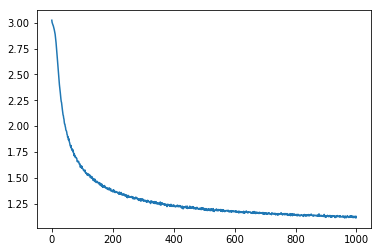

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = plt.plot(log_df.train_loss)

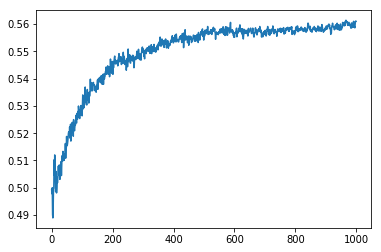

In [18]:
_ = plt.plot(log_df.test_score)

In [19]:
tf.keras.models.save_model(single_model, 'output/ontonotes-cruys2014.hd5')